<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Chapter 5. Spot Check Version 1</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<a id='4.1'>
    <h2 style='font-size:180%;'>
        Libraries</h2></a>

In [1]:
# binary classification spot check script
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import (RandomUnderSampler, TomekLinks, EditedNearestNeighbours)
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

import time

In [2]:
# settings
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True, precision=3)

In [3]:
%%html
<style>
/* CSS styles for pandas dataframe */
.dataframe th {
    font-size: 16px;
}
.dataframe td {
    font-size: 14px;
}
</style>

In [4]:
time_0 = time.perf_counter()

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Spot Check for Model & Scaler</h2>

## Load Data

In [5]:
# load the dataset, returns X and y elements
def load_dataset():
    d = pd.read_csv('source/d_num.csv')
    d_values = d.values
    x, y = d_values[:,1:], d_values[:,:1].ravel()
    return x, y

## Define Models

In [6]:
# create a dict of standard models to evaluate {name:object}
def define_models(models=list()):
    # linear
    i = 1000
    models.append(('LR', LogisticRegression(solver='saga', max_iter=i, class_weight='balanced', random_state=5))) # note: `max_iter` from 1000 to 10000 due to convergence issues
    # non-linear
    models.append(('DT', DecisionTreeClassifier(random_state=5)))
    i = 1000
    models.append(('MLP_' + str(i), MLPClassifier(max_iter=i, random_state=5)))
    # ensemble
    t = 800
    models.append(('ADA_' + str(t), AdaBoostClassifier(n_estimators=t, random_state=5))) 
    models.append(('GB_' + str(t), GradientBoostingClassifier(n_estimators=t, random_state=5))) # note: `max_iter` from 100 to 1000 due to convergence issues
    print(f'Defined {len(models)} models.')
    return models

## Define Resamplers

[Source: How to Combine Oversampling and Undersampling for Imbalanced Classification, *Machine Learning Mastery*](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)
<br>[Source: Undersampling Algorithms for Imbalanced Classification, *Machine Learning Mastery*](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/)

In [7]:
# create a dict of standard models to evaluate {name:object}
def define_resamplers(resamplers=list()):
    resamplers.append(('SM', SMOTE(random_state=5, n_jobs=-1)))
    resamplers.append(('SM_TM', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')))) 
    resamplers.append(('SM_ENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority')))) 
    print(f'Defined {len(resamplers)} resamplers.')
    return resamplers

## Build Pipelines

In [8]:
# normalize and standardize transform pipeline : RS
def pipeline_RS_SS(model, resampler):
    resampler = None
    steps = list()
    # normalization
    steps.append(('RS', RobustScaler()))
    # standardization
    steps.append(('SS', StandardScaler()))
    # the model
    steps.append(('MOD', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

# normalize and standardize transform pipeline : QT + Resampling
def pipeline_QT_SS_resample(model, resampler):
    steps = list()
    # normalization
    steps.append(('QT', QuantileTransformer()))
    # standardization
    steps.append(('SS', StandardScaler()))
    # the resampler
    steps.append(('RSP', resampler))
    # the model
    steps.append(('MOD', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

# normalize and standardize transform pipeline : RS + Resampling
def pipeline_RS_SS_resample(model, resampler):
    steps = list()
    # normalization
    steps.append(('RS', RobustScaler()))
    # standardization
    steps.append(('SS', StandardScaler()))
    # the resampler
    steps.append(('RSP', resampler))
    # the model
    steps.append(('MOD', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

## Evaluate Models

In [9]:
# evaluate a single model
def evaluate_model(X, y, model, resampler, folds, metric, pipe_func):
    # create the pipeline
    pipeline = pipe_func(model, resampler)
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
    return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, resampler, folds, metric, pipe_func):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, resampler, folds, metric, pipe_func)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, resamplers, pipe_funcs, folds=10, metric='recall'):
    results = dict()
    for name_model, model in models:
        for name_resampler, resampler in resamplers:
            # evaluate model under each preparation function
            for i in range(len(pipe_funcs)):
                # evaluate the model
                scores = robust_evaluate_model(X, y, model, resampler, folds, metric, pipe_funcs[i])
                # update name
                run_name = str(i) + '_' + name_model + '_' + name_resampler
                # show process
                if scores is not None:
                    # store a result
                    results[run_name] = scores
                    mean_score, std_score = np.nanmean(scores), np.nanstd(scores)
                    print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
                else:
                    print('>%s: error' % run_name)
    return results

## Examine Results

In [10]:
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k, np.nanmean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = np.nanmean(results[name]), np.nanstd(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')

## Run Results

Across all models, the SMOTE oversampling method in conjunction with the Edited Nearest Neighbor undersampling performed the best. Among the predictive algorithms, GB, ADA, and LR look promising. In the next session, we will narrow down our models and jump into hyperparameter tuning.

Defined 5 models.
Defined 3 resamplers.
>0_LR_SM: 0.855 (+/-0.067)
>1_LR_SM: 0.849 (+/-0.090)
>2_LR_SM: 0.844 (+/-0.066)
>0_LR_SM_TM: 0.855 (+/-0.067)
>1_LR_SM_TM: 0.844 (+/-0.094)
>2_LR_SM_TM: 0.843 (+/-0.070)
>0_LR_SM_ENN: 0.855 (+/-0.067)
>1_LR_SM_ENN: 0.870 (+/-0.107)
>2_LR_SM_ENN: 0.868 (+/-0.075)
>0_DT_SM: 0.755 (+/-0.091)
>1_DT_SM: 0.773 (+/-0.099)
>2_DT_SM: 0.782 (+/-0.098)
>0_DT_SM_TM: 0.755 (+/-0.091)
>1_DT_SM_TM: 0.774 (+/-0.099)
>2_DT_SM_TM: 0.762 (+/-0.098)
>0_DT_SM_ENN: 0.755 (+/-0.091)
>1_DT_SM_ENN: 0.840 (+/-0.074)
>2_DT_SM_ENN: 0.833 (+/-0.084)
>0_MLP_1000_SM: 0.743 (+/-0.160)
>1_MLP_1000_SM: 0.757 (+/-0.159)
>2_MLP_1000_SM: 0.755 (+/-0.171)
>0_MLP_1000_SM_TM: 0.743 (+/-0.160)
>1_MLP_1000_SM_TM: 0.757 (+/-0.157)
>2_MLP_1000_SM_TM: 0.762 (+/-0.165)
>0_MLP_1000_SM_ENN: 0.743 (+/-0.160)
>1_MLP_1000_SM_ENN: 0.840 (+/-0.100)
>2_MLP_1000_SM_ENN: 0.867 (+/-0.078)
>0_ADA_800_SM: 0.811 (+/-0.108)
>1_ADA_800_SM: 0.842 (+/-0.075)
>2_ADA_800_SM: 0.836 (+/-0.090)
>0_ADA_800_SM_TM: 

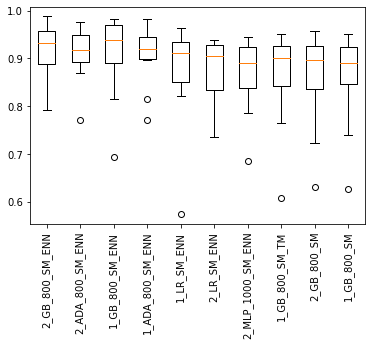

In [11]:
# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# get model list
resamplers = define_resamplers()
# define transform pipelines
pipelines = [pipeline_RS_SS, pipeline_QT_SS_resample, pipeline_RS_SS_resample]
# evaluate models
results = evaluate_models(X, y, models, resamplers, pipelines)
# summarize results
summarize_results(results)

## Calculate Runtime

In [12]:
time_1 = time.perf_counter()

In [13]:
print(f'Finished in {round(time_1-time_0, 2):,} second(s) or {round((time_1-time_0)/60, 2)} minute(s).')

Finished in 5,876.78 second(s) or 97.95 minute(s).


In [ ]:
# Rank=1, Name=2_GB_800_SM_ENN, Score=0.914 (+/- 0.063)
# Rank=2, Name=2_ADA_800_SM_ENN, Score=0.910 (+/- 0.056)
# Rank=3, Name=1_GB_800_SM_ENN, Score=0.908 (+/- 0.087)
# Rank=4, Name=1_ADA_800_SM_ENN, Score=0.906 (+/- 0.063)
# Rank=5, Name=1_LR_SM_ENN, Score=0.870 (+/- 0.107)
# Rank=6, Name=2_LR_SM_ENN, Score=0.868 (+/- 0.075)
# Rank=7, Name=2_MLP_1000_SM_ENN, Score=0.867 (+/- 0.078)
# Rank=8, Name=1_GB_800_SM_TM, Score=0.859 (+/- 0.099)
# Rank=9, Name=2_GB_800_SM, Score=0.857 (+/- 0.099)
# Rank=10, Name=1_GB_800_SM, Score=0.857 (+/- 0.096)